# Loading the necessary modules

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, accuracy_score, roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading the data:
## (Rows with NA's and features with too many missing values have been removed already)

In [15]:
data_full = pd.read_csv('B3_working.csv', low_memory = False)

# Scaling the design matrix and transforming the response
Here we simply use the min-max scaler and we change the response to 0 and 1 (0 for the class BBB+ and 1 for the class BBB-)

In [16]:
X = np.array(data_full.loc[:, data_full.columns != 'y'])
mm = MinMaxScaler()
X = mm.fit_transform(X)
y = data_full['y']
le = LabelEncoder()
le.fit(y)
y = le.transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6220, 1189)
(6220,)
(1555, 1189)
(1555,)


In [17]:
y_test

array([0, 0, 0, ..., 0, 1, 1])

# Making Neural Network model with only 2 hidden layers
Here for the last layer we have used the usual sigmoid function to get the corresponding class probabilites

In [32]:
nn_model = tf.keras.Sequential()
nn_model.add(Dense(128, activation = 'relu'))
nn_model.add(Dense(32, activation = 'relu'))
nn_model.add(Dense(1, activation = 'sigmoid'))

In [33]:
nn_model.compile(
    optimizer = 'Adam',
    loss =  BinaryCrossentropy(),
    metrics = ['accuracy']
)

In [34]:
nn_model.fit(X_train, y_train, epochs = 50, validation_data = (X_test, y_test), verbose = 0)

In [35]:
nn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               152320    
                                                                 
 dense_7 (Dense)             (None, 32)                4128      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 156,481
Trainable params: 156,481
Non-trainable params: 0
_________________________________________________________________


# After fitting the model let us obtain the prediction probabilities for the class BBB-

In [22]:
y_pred_proba = nn_model.predict(X_test)

49/49 [==============================] - 0s 614us/step


In [23]:
y_pred_proba

array([[5.5576498e-03],
       [2.0184502e-02],
       [4.3363380e-03],
       ...,
       [2.3497020e-04],
       [9.9225956e-01],
       [4.0390620e-01]], dtype=float32)

## To get the optimal threshold for the classification we compare the F-scores for several threshold values

In [24]:
def f_thresh(x, probs, y_true):
    yp = probs > x
    yp = yp.astype(int)
    f =  f1_score(y_true, yp)
    return f
thresh_vals = np.arange(0.1, 0.9, 0.01)
f_vals = [f_thresh(y, probs = y_pred_proba, y_true = y_test) for y in thresh_vals]

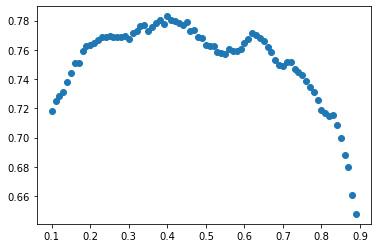

In [25]:
plt.scatter(x = thresh_vals, y=f_vals)
plt.show()

In [26]:
ind = f_vals.index(max(f_vals))

We see that the optimal threshold comes out to be 0.33 which is very close to the one obtained using Random Forest

In [27]:
opt_thresh = thresh_vals[ind]
print(opt_thresh)

0.3999999999999998


Using this threshold value we get the F-score on the test set to be around 0.80 and the accuracy to be around 0.856 which is lower than what we obtained using the Random Forest

In [37]:
y_pred = y_pred_proba > opt_thresh
print(confusion_matrix(y_pred = y_pred, y_true = y_test))
f1_score(y_true = y_test, y_pred = y_pred)

[[871 141]
 [103 440]]


0.7829181494661922

In [29]:
accuracy_score(y_true = y_test, y_pred = y_pred)

0.8430868167202572

Finally, the ROC is as follows

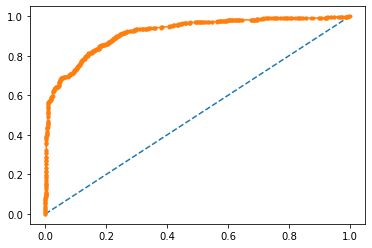

In [30]:
ns_probs = np.zeros(y_test.shape[0])
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.')

and the AUC is around 0.926

In [31]:
roc_auc_score(y_test, y_pred_proba)

0.9187121030142889